## Sift Evaluator

The objectives of this notebook are to:

- Define functions that query the data based on different parameters (distance metric, transformations?)
- Define functions to evaluate the truth of each returned query parameter
- Define functions to calculate mAP and precision@k for the above output
- Create a pipeline for evaluating the effects of different parameter set ups / transformations on mAP and p@k

______
# Evaluation Functions
____
### Imports

In [64]:
import numpy as np
import unittest
import sklearn.metrics.pairwise
import sklearn.preprocessing
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import time
import glob
import copy

____
### Query Functions

In [2]:
def basic_query(query_image_features, query_target_features, metric_function = sklearn.metrics.pairwise.euclidean_distances):
    """Return the indexes of the query_target images, arranged in ascending euclidean distance as compared to the query image"""
    
    query = query_image_features.reshape((1, -1))
    D = metric_function(query_target_features, query).squeeze()
    index = np.argsort(D)

    return(index)


_____
### Query to Truth Value Functions

In [3]:
def query_results_to_truth_values(query_image_building, query_results, image_names):
    """Convert the index results of a query to an array of booleans corresponding to whether the correct image was retrieved."""
    return([query_image_building == image_names[index] for index in query_results])

_______
### Truth Value Metrics Functions

In [4]:
## Potential Improvements
# 1. Precision_at_k to print precision at last true value?
# 2. Create a more computationally efficient (/combined?) version.
# 3. Add recall_at_k

def precision_at_k(truth_values, k, warnings=True):
    """Return proportions of true values in the first k elements.
    If warnings=True and all true values occur before the kth element, raise an error"""
    p_at_k = truth_values[:k].count(True) / k

    if warnings:
        if k < len(truth_values):
            if truth_values[k:].count(True) == 0:
                raise ValueError("All true values are before the first k values")
    
    return(p_at_k)


def average_precision(truth_values):
    """Given a boolean input of whether returned query values are correct or false, return the average precision.
    e.g. average_precision([True, True, False, True]) ~ 0.85
    """
    precisions = []
    for (index, val) in enumerate(truth_values):
        if val: # == True
            precisions.append(truth_values[:index + 1].count(True) / (index + 1))      

    return(np.mean(precisions))

____
### Total Metrics


In [5]:
def compute_metrics(train_features, test_features, train_names, test_names, query_function, metric_function, average_mean_precision = True, k_values = [5,10,20]):
    """Run each test feature against the train features,"""
    average_precisions = []
    precisions_at_k = {}
    for k in k_values:
        precisions_at_k[k] = []
    
    for (test_feature, test_feature_name) in zip(test_features.iterrows(), test_names):
        query_image_features = test_feature[1].values # extract the values for the iterrows row object
        query_results = query_function(query_image_features, train_features, metric_function)
        truth_values = query_results_to_truth_values(test_feature_name, query_results, train_names)
        
        average_precisions.append(average_precision(truth_values))
        for k in precisions_at_k:
            p_at_k = precision_at_k(truth_values, k, warnings=False)
            precisions_at_k[k].append(p_at_k)
    
    for (k_value, list_of_precisions) in precisions_at_k.items():
        precisions_at_k[k_value] = np.mean(list_of_precisions)
    
    return(np.mean(average_precisions), precisions_at_k)


## Outdated version

# def mean_average_precision(train_features, test_features, train_names, test_names, distance_metric):
#     """descriptive docstring do map yeah"""
#     average_precisions = []
    
#     for (test_feature, test_feature_name) in zip(test_features.iterrows(), test_names):
#         features_as_array = test_feature[1].values # extract the values for the iterrows row object
#         query_results = basic_query(features_as_array, train_features, distance_metric)
#         truth_values = query_results_to_truth_values(test_feature_name, query_results, train_names)
#         average_precisions.append(average_precision(truth_values))
    
#     return(np.mean(average_precisions))

___________
### Tests

In [6]:
class TestQuery(unittest.TestCase):

    def test_basicquery(self):
        test_query = np.array([0,0,0,0])
        test_query_target = pd.DataFrame(data={"a" : [4,0,0,0],
                             "b" : [0,1,2,0],
                             "c" : [0,0,0,0],
                             "d" : [0,0,0,6]})
        self.assertTrue(np.allclose(basic_query(test_query, test_query_target), [1,2,0,3]))

class TestTruthValues(unittest.TestCase):

    def test_queryresultstotruthvalues(self):
        test_query_image_building = "A"
        test_query_results = [0,4,3,2,1,5,6]
        test_image_names = ["A", "B", "C", "D", "A", "A", "D"]
        results = query_results_to_truth_values(test_query_image_building, test_query_results, test_image_names)
        self.assertTrue(np.array_equal(results, [True, True, False, False, False, True, False]))

class TestMetrics(unittest.TestCase):

    def test_precision_at_k(self):
        self.assertEqual(precision_at_k([True,False,True, True],4), 0.75)
        self.assertEqual(precision_at_k([True, False, True, False, True], 2), 0.5)

    def test_averageprecision(self):
        self.assertAlmostEqual(average_precision([True, False, True, True]), np.mean([1,2/3,3/4]))
        self.assertAlmostEqual(average_precision([False, False, True, False, True]), np.mean([1/3,2/5]))
    
    # def test_meanaverageprecision(self)


unittest.main(argv=[''], verbosity=2, exit=False)

test_averageprecision (__main__.TestMetrics) ... ok
test_precision_at_k (__main__.TestMetrics) ... ok
test_basicquery (__main__.TestQuery) ... ok
test_queryresultstotruthvalues (__main__.TestTruthValues) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


_______
# Data Loading

_____________
## Names and Images

In [7]:
a = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/roxford5k/easy/radcliffe_camera-507.jpg"
a.split("/")[-1]

'radcliffe_camera-507.jpg'

In [8]:
# Loading Function

def load_data(train_path, query_path):

    train_image_paths = []
    train_images = []
    train_names = []

    # save path to image and save class names as numbers (train)
    for data_path in glob.glob(train_path + '/*'):
        name = data_path.split('/')[-1].split("-")[0]
        train_names.append(name) 
        train_image_paths.append(data_path)
    
    # open image from path and save to array
    for img_path in train_image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(img)

    # save path to image and save class names as numbers (query)
    query_image_paths = []
    query_names = []
    query_images = []
    
    for data_path in glob.glob(query_path + '/*'):
        name = data_path.split('/')[-1].split("-")[0]
        query_names.append(name) 
        query_image_paths.append(data_path)
    
    # open image from path and save to array
    for img_path in query_image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        query_images.append(img)

    print("Train Images: {} | Query Images: {}".format(len(train_images), len(query_images)))
    return train_images, train_names, query_images, query_names

In [9]:
# Load roxford5k

option = 'easy'
train_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/roxford5k/{}".format(option)
query_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/roxford5k/query"

ox_easy_images, ox_easy_names, ox_query_images, ox_query_names = load_data(train_path, query_path)

option = 'hard'
train_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/roxford5k/{}".format(option)
query_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/roxford5k/query"

ox_hard_images, ox_hard_names, ox_query_images, ox_query_names = load_data(train_path, query_path)

ox_medium_images = ox_easy_images + ox_hard_images
ox_medium_names = ox_easy_names + ox_hard_names

Train Images: 516 | Query Images: 70
Train Images: 685 | Query Images: 70


In [10]:
# Load rparis6k

option = 'easy'
train_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/rparis6k/{}".format(option)
query_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/rparis6k/query"

par_easy_images, par_easy_names, par_query_images, par_query_names = load_data(train_path, query_path)

option = 'hard'
train_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/rparis6k/{}".format(option)
query_path = "/home/sean/Code/Pawsey/3. Data/Revised and Sorted/rparis6k/query"

par_hard_images, par_hard_names, par_query_images, par_query_names = load_data(train_path, query_path)

par_medium_images = par_easy_images + par_hard_images
par_medium_names = par_easy_names + par_hard_names

Train Images: 1470 | Query Images: 70
Train Images: 1978 | Query Images: 70


In [12]:
names = {"ox" : {"easy" : ox_easy_names,
                 "medium" :ox_medium_names,
                 "hard" : ox_hard_names,
                 "query" : ox_query_names},
         "par" : {"easy" : par_easy_names,
                  "medium" : par_medium_names,
                  "hard" : par_hard_names,
                  "query" : par_query_names}}

_____
## Sift Features

In [61]:
sift_dir = "/home/sean/Code/Pawsey/2. Revised Data Analysis/Oldenburger Data Files/SIFT"
sift_raw = {"ox" : {}, "par" :{}}

os.chdir(sift_dir)
for file_name in os.listdir():
    split_name = file_name[:-4].split("-")
    dataset, difficulty, num_features = split_name

    num_features = int(num_features)
    if num_features not in sift_raw[dataset].keys():
        sift_raw[dataset][num_features] = {}
    
    sift_raw[dataset][num_features][difficulty] = pd.DataFrame(np.load(file_name))

sift_raw["ox"][1000]["easy"]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.222562,0.107324,-0.096406,-0.042793,-0.166953,0.115800,0.023228,0.046255,-0.052713,0.037768,...,0.003417,0.002296,-0.000992,0.004535,-0.000660,-0.002533,-0.000543,0.005779,0.004640,-0.001291
1,-0.143654,-0.243126,-0.146313,0.148875,-0.114526,-0.113641,-0.064977,0.112074,-0.148714,0.028721,...,0.000689,-0.000611,-0.001790,-0.004445,-0.005078,0.002574,0.002198,-0.003624,0.000931,-0.002079
2,-0.182766,0.112678,-0.072608,-0.066618,-0.151153,0.145077,0.016828,-0.000937,-0.058925,0.030486,...,0.001243,0.006297,0.002810,0.007026,-0.003762,-0.001334,0.003043,0.003580,0.000501,-0.001501
3,-0.162958,-0.195413,-0.201296,-0.007927,0.006130,-0.013056,-0.074896,0.119956,-0.042482,0.024529,...,-0.002553,-0.000959,-0.000534,0.001421,0.004909,-0.002227,-0.001403,0.003236,-0.001630,0.001046
4,-0.156370,-0.175493,-0.233327,0.003510,0.057135,0.071303,-0.063093,0.068845,0.037527,0.048635,...,-0.001858,-0.000473,-0.002242,0.002499,-0.001076,0.000346,-0.000612,0.001374,0.001420,0.002370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.008675,-0.364543,-0.034069,0.030281,-0.073821,-0.109432,0.161836,-0.136757,0.110383,0.058745,...,0.001099,-0.001491,-0.001246,-0.001753,0.001646,0.000618,0.003733,0.000092,-0.000043,-0.000278
512,-0.002103,-0.361036,0.056904,-0.049549,0.061208,-0.070501,0.100968,-0.003870,0.064122,-0.011988,...,0.002773,-0.002792,-0.003951,-0.003102,-0.001206,-0.002207,-0.003269,0.003815,-0.003498,-0.001653
513,0.010216,-0.358101,0.091496,0.008245,0.023822,-0.127268,0.205493,0.021845,0.175781,-0.181827,...,0.004471,-0.001939,0.000826,0.004236,-0.005485,0.002993,-0.002058,0.002255,0.006579,0.004411
514,0.165959,-0.310917,-0.216677,-0.067044,0.173877,0.053991,0.198769,-0.001055,-0.021094,0.125117,...,-0.002309,-0.000165,0.000492,0.000051,0.001506,0.001901,-0.000668,-0.000263,0.000772,0.000626


____
### Apply Vertical and Horizontal Normalisation

In [65]:
full_data = {"raw" : sift_raw,
             "vector norm" : copy.deepcopy(sift_raw),
             "feature norm" : copy.deepcopy(sift_raw)}

for dataset in sift_raw:
    for num_features in sift_raw[dataset]:
        for difficulty in sift_raw[dataset][num_features]:
            
            df = full_data["vector norm"][dataset][num_features][difficulty]
            vector_norm_df = sklearn.preprocessing.normalize(df, axis=1)
            full_data["vector norm"][dataset][num_features][difficulty] = vector_norm_df
    
        dfs = full_data["feature norm"][dataset][num_features]
        print(dataset)
        print(num_features)
        column_means = dfs["medium"].apply(np.mean)
        column_stds = dfs["medium"].apply(np.std)
        for (difficulty, base_df) in dfs.items():
            minus_means = base_df.copy() - column_means
            div_std = minus_means / column_stds
            full_data["feature norm"][dataset][num_features][difficulty] = div_std


ox
10000


AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [ ]:
copy.deepcopy

In [69]:
sift_raw["ox"][1000]["easy"]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.222562,0.107324,-0.096406,-0.042793,-0.166953,0.115800,0.023228,0.046255,-0.052713,0.037768,...,0.003417,0.002296,-0.000992,0.004535,-0.000660,-0.002533,-0.000543,0.005779,0.004640,-0.001291
1,-0.143654,-0.243126,-0.146313,0.148875,-0.114526,-0.113641,-0.064977,0.112074,-0.148714,0.028721,...,0.000689,-0.000611,-0.001790,-0.004445,-0.005078,0.002574,0.002198,-0.003624,0.000931,-0.002079
2,-0.182766,0.112678,-0.072608,-0.066618,-0.151153,0.145077,0.016828,-0.000937,-0.058925,0.030486,...,0.001243,0.006297,0.002810,0.007026,-0.003762,-0.001334,0.003043,0.003580,0.000501,-0.001501
3,-0.162958,-0.195413,-0.201296,-0.007927,0.006130,-0.013056,-0.074896,0.119956,-0.042482,0.024529,...,-0.002553,-0.000959,-0.000534,0.001421,0.004909,-0.002227,-0.001403,0.003236,-0.001630,0.001046
4,-0.156370,-0.175493,-0.233327,0.003510,0.057135,0.071303,-0.063093,0.068845,0.037527,0.048635,...,-0.001858,-0.000473,-0.002242,0.002499,-0.001076,0.000346,-0.000612,0.001374,0.001420,0.002370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.008675,-0.364543,-0.034069,0.030281,-0.073821,-0.109432,0.161836,-0.136757,0.110383,0.058745,...,0.001099,-0.001491,-0.001246,-0.001753,0.001646,0.000618,0.003733,0.000092,-0.000043,-0.000278
512,-0.002103,-0.361036,0.056904,-0.049549,0.061208,-0.070501,0.100968,-0.003870,0.064122,-0.011988,...,0.002773,-0.002792,-0.003951,-0.003102,-0.001206,-0.002207,-0.003269,0.003815,-0.003498,-0.001653
513,0.010216,-0.358101,0.091496,0.008245,0.023822,-0.127268,0.205493,0.021845,0.175781,-0.181827,...,0.004471,-0.001939,0.000826,0.004236,-0.005485,0.002993,-0.002058,0.002255,0.006579,0.004411
514,0.165959,-0.310917,-0.216677,-0.067044,0.173877,0.053991,0.198769,-0.001055,-0.021094,0.125117,...,-0.002309,-0.000165,0.000492,0.000051,0.001506,0.001901,-0.000668,-0.000263,0.000772,0.000626


In [13]:
oxford5k["vector norm"] = {"test" : {}, "train": {}}
oxford5k["feature norm"] = {"test" : {}, "train": {}}

for bovw_size in oxford5k["raw features"]["train"].keys():
    full_df = pd.concat([oxford5k["raw features"]["train"][bovw_size],
                         oxford5k["raw features"]["test"][bovw_size]],
                         ignore_index=True)

    feature_norm = sklearn.preprocessing.normalize(full_df, axis=0)
    oxford5k["feature norm"]["train"][bovw_size] = pd.DataFrame(feature_norm[:567,:])
    oxford5k["feature norm"]["test"][bovw_size] = pd.DataFrame(feature_norm[567:,:])

    vector_norm = sklearn.preprocessing.normalize(full_df, axis=1)
    oxford5k["vector norm"]["train"][bovw_size] = pd.DataFrame(vector_norm[:567,:])
    oxford5k["vector norm"]["test"][bovw_size] = pd.DataFrame(vector_norm[567:,:])

oxford5k["feature norm"]["test"]["bovw files for 100 Words"].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.033827,0.035713,0.030498,0.018938,0.022437,0.022456,0.077555,0.051392,0.013825,0.056622,...,0.046860,0.058236,0.041051,0.047852,0.024786,0.018312,0.036336,0.060646,0.023192,0.043599
1,0.011270,0.065442,0.036901,0.039666,0.030566,0.033093,0.029715,0.048888,0.045024,0.027695,...,0.039898,0.036126,0.046472,0.051336,0.035612,0.022452,0.031476,0.024603,0.034499,0.037122
2,0.010666,0.061128,0.029933,0.061474,0.016788,0.028634,0.026782,0.047735,0.044757,0.029954,...,0.016182,0.048841,0.028997,0.037181,0.025678,0.025295,0.022914,0.040654,0.039574,0.035131
3,0.027230,0.038022,0.045059,0.039964,0.046902,0.053649,0.048526,0.089966,0.048509,0.033818,...,0.038093,0.073704,0.023961,0.028580,0.029607,0.038643,0.034912,0.041547,0.030148,0.044364
4,0.007698,0.048766,0.026887,0.038329,0.011744,0.045210,0.044462,0.070499,0.050655,0.037836,...,0.040881,0.033386,0.017581,0.030057,0.020542,0.017892,0.029770,0.063489,0.031421,0.020286


In [14]:
# ## actual correct way to do transformations, currently not working?

# # normalising the columns
# train_feature_norm = {}
# test_feature_norm = {}

# # normalising the rows
# train_vector_norm = {}
# test_vector_norm = {}

# for bovw_size in train_features.keys():
#     train = train_features[bovw_size]
#     test = test_features[bovw_size]

#     row_normaliser = sklearn.preprocessing.Normalizer().fit(train)
#     train_vector_norm[bovw_size] = row_normaliser.transform(train)
#     test_vector_norm[bovw_size] = row_normaliser.transform(test)

#     # rotate dataframes to normalise by column
#     temp_train = train.T
#     temp_test = test.T
#     column_normaliser = sklearn.preprocessing.Normalizer().fit(temp_train)
#     train_feature_norm[bovw_size] = column_normaliser.transform(temp_train).T
#     test_feature_norm[bovw_size] = column_normaliser.transform(temp_test).T

# train_feature_norm(["bovw files for 10 Words"]) == sklearn.preprocessing.normalize(train_features["bovw files for 10 Words"], axis=0)

# dat = pd.DataFrame({1:[10,-10, 5], 2:[4,-1, 4]})

# def normalise_vector(vector, mean=None, stdev=None):
#     if not mean:
#         mean = np.mean(vector)
#     if not stdev:
#         stdev = np.std(vector)
#     return((vector-mean)/stdev)

# dat.apply(normalise_vector, axis=0)

_____
### Sample Query

In [15]:
# Sample query validated against Sean Oldenburger's method

compute_metrics(train_features = oxford5k["raw features"]["train"]["bovw files for 10 Words"],
                test_features = oxford5k["raw features"]["test"]["bovw files for 10 Words"],
                train_names = oxford5k["attributes"]["train"]["names"],
                test_names = oxford5k["attributes"]["test"]["names"],
                query_function=basic_query,
                metric_function = sklearn.metrics.pairwise.euclidean_distances)

(0.2846602906055916,
 {5: 0.4763636363636364, 10: 0.3636363636363636, 20: 0.2818181818181818})

____
### Test all experimental setups

In [29]:
test_distance_metrics = {"euclidean" : sklearn.metrics.pairwise.euclidean_distances,
           "cosine" : sklearn.metrics.pairwise.cosine_distances,
           "manhattan" :sklearn.metrics.pairwise.manhattan_distances,
           "nan_euclidean" : sklearn.metrics.pairwise.nan_euclidean_distances}

In [62]:
results = {"distance_metrics" : [], 'transformations' : [], 'bovw_sizes' : [], 'mean_aps' : []}
k_vals = [5, 10, 20]
for k in k_vals:
    results["precision at {}".format(k)] = []

for (metric_name, metric_function) in test_distance_metrics.items():
    for  transformation in ["raw features", "vector norm", "feature norm"]:
        train = oxford5k[transformation]["train"]
        test = oxford5k[transformation]["test"]
        
        for bovw_size in train.keys():
            (mean_ap, p_at_k) = compute_metrics(train_features = train[bovw_size],
                                                test_features = test[bovw_size],
                                                train_names = oxford5k["attributes"]["train"]["names"],
                                                test_names = oxford5k["attributes"]["test"]["names"],
                                                query_function=basic_query,
                                                metric_function = metric_function,
                                                k_values=k_vals)
            
            print("{} {} {} : {}".format(metric_name, transformation, bovw_size, mean_ap))
            results['distance_metrics'].append(metric_name)
            results['transformations'].append(transformation)
            results['bovw_sizes'].append(bovw_size.split(' ')[3])
            results['mean_aps'].append(mean_ap)
            for (k, p_at_k) in p_at_k.items():
                results["precision at {}".format(k)] = p_at_k


results_df = pd.DataFrame(results)
results_df


euclidean raw features bovw files for 10000 Words : 0.5160431683671248
euclidean raw features bovw files for 10 Words : 0.2846602906055916
euclidean raw features bovw files for 100 Words : 0.3836962289612868
euclidean raw features bovw files for 20000 Words : 0.5679781603977279
euclidean raw features bovw files for 100000 Words : 0.6682471101801445
euclidean raw features bovw files for 1000 Words : 0.4096111116568395
euclidean raw features bovw files for 50000 Words : 0.6198841133826765
euclidean vector norm bovw files for 10000 Words : 0.5160431683671248
euclidean vector norm bovw files for 10 Words : 0.2846602906055916
euclidean vector norm bovw files for 100 Words : 0.3836962289612868
euclidean vector norm bovw files for 20000 Words : 0.5679781603977279
euclidean vector norm bovw files for 100000 Words : 0.6682471101801445
euclidean vector norm bovw files for 1000 Words : 0.4096111116568395
euclidean vector norm bovw files for 50000 Words : 0.6198841133826765
euclidean feature norm 

,distance_metrics,transformations,bovw_sizes,mean_aps,precision at 5,precision at 10,precision at 20
0,euclidean,raw features,10000,0.516043,0.301818,0.238182,0.184545
1,euclidean,raw features,10,0.284660,0.301818,0.238182,0.184545
2,euclidean,raw features,100,0.383696,0.301818,0.238182,0.184545
3,euclidean,raw features,20000,0.567978,0.301818,0.238182,0.184545
4,euclidean,raw features,100000,0.668247,0.301818,0.238182,0.184545
5,euclidean,raw features,1000,0.409611,0.301818,0.238182,0.184545
6,euclidean,raw features,50000,0.619884,0.301818,0.238182,0.184545
7,euclidean,vector norm,10000,0.516043,0.301818,0.238182,0.184545
8,euclidean,vector norm,10,0.284660,0.301818,0.238182,0.184545
9,euclidean,vector norm,100,0.383696,0.301818,0.238182,0.184545


____
## Testing RANSAC Spatial Verification

In [11]:
k_values = [5]
stop = 1


average_precisions = []
precisions_at_k = {}
for k in k_values:
    precisions_at_k[k] = []

for (test_image, test_image_name) in zip(oxford5k["attributes"]["test"]["images"][:1], oxford5k["attributes"]["test"]["names"][:1]):
    query_results = ransac_query(test_image, oxford5k["attributes"]["train"]["images"])
    truth_values = query_results_to_truth_values(test_image_name, query_results, oxford5k["attributes"]["train"]["names"])
    
    average_precisions.append(average_precision(truth_values))
    for k in precisions_at_k:
        p_at_k = precision_at_k(truth_values, k, warnings=False)
        precisions_at_k[k].append(p_at_k)

for (k_value, list_of_precisions) in precisions_at_k.items():
    precisions_at_k[k_value] = np.mean(list_of_precisions)

results = (np.mean(average_precisions), precisions_at_k)
print(results)

(0.19656765964658499, {5: 0.0})


____
### Visualising results

In [63]:
pd.options.display.max_rows = 84
results_df.sort_values(by="mean_aps", ascending=False).head(10)

,distance_metrics,transformations,bovw_sizes,mean_aps,precision at 5,precision at 10,precision at 20
39,cosine,feature norm,100000,0.699703,0.301818,0.238182,0.184545
25,cosine,raw features,100000,0.668247,0.301818,0.238182,0.184545
74,nan_euclidean,vector norm,100000,0.668247,0.301818,0.238182,0.184545
32,cosine,vector norm,100000,0.668247,0.301818,0.238182,0.184545
67,nan_euclidean,raw features,100000,0.668247,0.301818,0.238182,0.184545
11,euclidean,vector norm,100000,0.668247,0.301818,0.238182,0.184545
4,euclidean,raw features,100000,0.668247,0.301818,0.238182,0.184545
41,cosine,feature norm,50000,0.648848,0.301818,0.238182,0.184545
6,euclidean,raw features,50000,0.619884,0.301818,0.238182,0.184545
27,cosine,raw features,50000,0.619884,0.301818,0.238182,0.184545


Odd:
cosine feature norm bovw files for 100000 Words : 0.6997034939349722
euclidean feature norm bovw files for 100000 Words : 0.20411431859694523

/home/sean/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sean/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


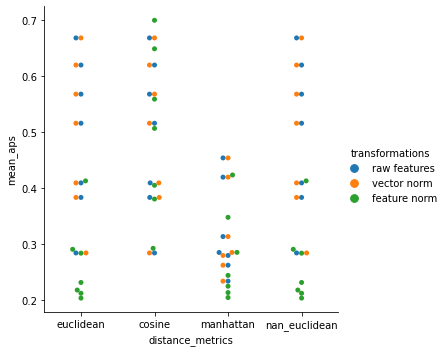

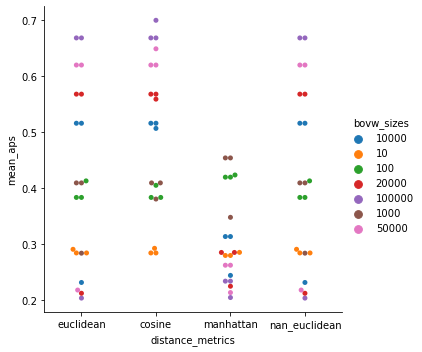

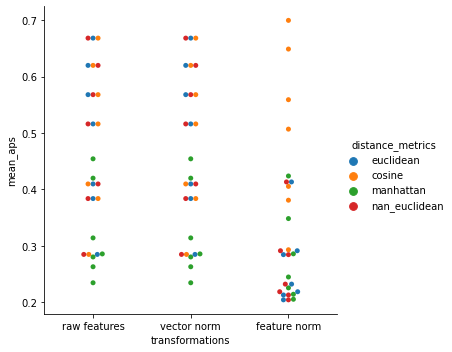

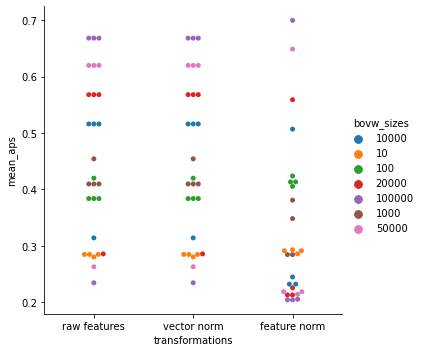

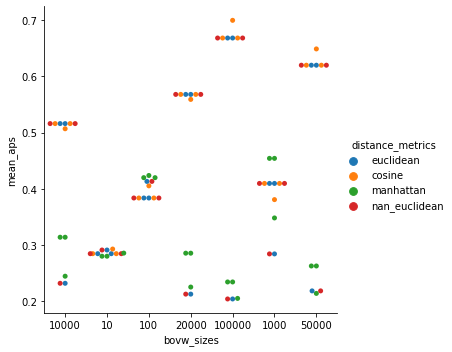

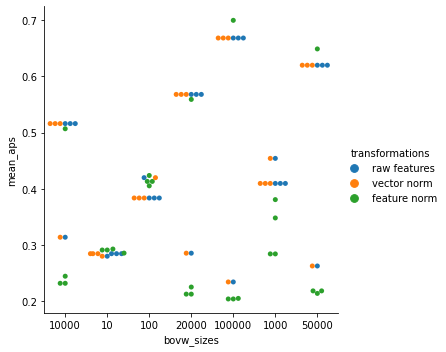

In [65]:
for column1 in results_df.columns[:3]:
    for column2 in results_df.columns[:3]:
        if column1 != column2:
            sns.catplot(x=column1, y="mean_aps", data=results_df, kind="swarm", hue=column2)

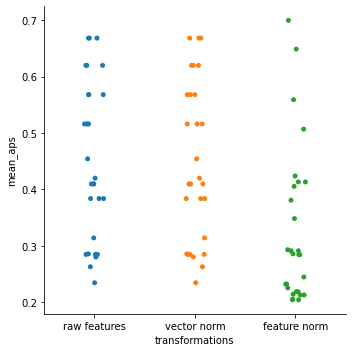

In [56]:
sns.catplot(x="transformations", y="mean_aps", data=results_df)